In [24]:
from scipy import optimize, stats
from Auction.SecondPriceAuction import SecondPriceAuction
from Auction.MultiplicativePacingAgent import MultiplicativePacingAgent
import numpy as np
import matplotlib.pyplot as plt
import argparse
from Auction.UCBAgent import UCBAgent

#pricing
from Pricing.GPThompson import GPThompson
from Pricing.GPUCBAgent import GPUCBAgent
from Pricing.GPThompsonContinuous import GPThompsonContinuous
from Pricing.GPUCBAgentContinuous import GPUCBAgentContinuous
from Pricing.StochasticPricingEnvironment import StochasticPricingEnvironment
#from visualization import showPlotRegrets,showCombinedPlots,showPlotPulls, showCombinedPlotOneAgent

import numpy as np 

In [25]:
#functions

def get_clairvoyant_truthful(B, my_valuation, m_t, n_users):
    ## I compute my sequence of utilities at every round
    utility = (my_valuation-m_t)*(my_valuation>=m_t)
    ## Now I have to find the sequence of m_t summing up to budget B and having the maximum sum of utility
    ## In second price auctions, I can find the sequence **greedily**:
    sorted_round_utility = np.flip(np.argsort(utility)) # sorted rounds, from most profitable to less profitable
    clairvoyant_utilities = np.zeros(n_users)
    clairvoyant_bids= np.zeros(n_users)
    clairvoyant_payments = np.zeros(n_users)
    c = 0
    i = 0
    while c <= B-1 and i < n_users:
        clairvoyant_bids[sorted_round_utility[i]] = 1
        clairvoyant_utilities[sorted_round_utility[i]] = utility[sorted_round_utility[i]]
        clairvoyant_payments[sorted_round_utility[i]] = m_t[sorted_round_utility[i]]
        c += m_t[sorted_round_utility[i]]
        i+=1
    return clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments

def discretize(T):
    epsilon = T**(-0.33)
    K = int(np.ceil(1/epsilon))
    return K

def rescale(x, min_x, max_x):
    return min_x + (max_x-min_x)*x

def initialize_stoch_auctions(args):
    # noise in the environment
    #eta = 1/np.sqrt(args.n_users*args.T)
    eta = 0.01
    if args.bidding_agent == 'ucb':
        K_disc = discretize(args.T*args.n_users)
        print('INITIALIZING UCB BIDDING AGENT...')
        adv_agent = UCBAgent(
            valuation=args.valuation,
            budget=args.B,
            n_users=args.n_users,
            T=args.T,
            K=K_disc
            
        )
    else:
        print('INITIALIZING MULTIPLICATIVE BIDDING AGENT...')
        adv_agent = MultiplicativePacingAgent(
            valuation=args.valuation,
            budget=args.B,
            T=args.T, 
            n_users= args.n_users,
            eta=eta
        )
    auction = SecondPriceAuction(args.ctrs)


    return auction, adv_agent

def initialize_stoch_pricing(args):
    K = discretize(args.T)
    prices = np.linspace(args.min_price, args.max_price, K)
    reward_function = lambda price, n_sales: (price-args.cost)*n_sales
    maximum_profit = reward_function(max(prices), args.n_customers)
    # the maximum possible reward is selling at the maximum price to every possible customer

    # conversion prob
    conversion_probability = lambda p: 1-p/20 #TODO: try to change it
            
    # clairvoyant
    profit_curve = reward_function(np.linspace(args.min_price, args.max_price, 1000), args.n_customers*conversion_probability(np.linspace(args.min_price, args.max_price, 1000)))
    best_price_index = np.argmax(profit_curve)
    #best_price = prices[best_price_index]
           
           
    expected_clairvoyant_rewards = np.repeat(profit_curve[best_price_index], args.T)
    if args.discretize_price==1:
        
        if args.pricing_agent == 'ucb':
            print('INITIALIZING DISCRETIZED UCB PRICING AGENT...')
            gp_agent = GPUCBAgent(args.T, discretization=K)
        else:
            print('INITIALIZING DISCRETIZED THOMPSON PRICING AGENT...')
            gp_agent = GPThompson(args.T, discretization=K)    
    else:
        if args.pricing_agent == 'ucb':
            print('INITIALIZING CONTINUOUS UCB PRICING AGENT...')
            gp_agent = GPUCBAgentContinuous(args.T)
        else:
            print('INITIALIZING CONTINUOUS THOMPSON PRICING AGENT...')
            gp_agent = GPThompsonContinuous(args.T)
    env = StochasticPricingEnvironment(
        conversion_probability=lambda p: 1-p/20,
        cost=args.cost
    )
    return gp_agent, env, expected_clairvoyant_rewards 
        
def loop_auction_day(auction, agent, other_bids,seed, n_users=1000):
    utilities = np.array([])
    my_bids = np.array([])
    my_payments = np.array([])
    total_wins = 0
    m_t = other_bids.max(axis=0)

    np.random.seed(seed)
    for u in range(n_users):
        # interaction
        my_bid = agent.bid()
        bids = np.append(my_bid, other_bids[:, u].ravel())
        winners, payments_per_click = auction.round(bids=bids)
        my_win = int(winners==0)
        f_t, c_t = (args.valuation-m_t[u])*my_win, m_t[u]*my_win
        agent.update(f_t, c_t)
        # logging
        utilities = np.append(utilities, f_t)
        my_bids = np.append(my_bids, my_bid)
        my_payments = np.append(my_payments, c_t)
        total_wins+=my_win
    #print(f'Total # of Wins: {total_wins}')

    return utilities, my_bids, my_payments, total_wins



In [26]:
def parse():
    parser = argparse.ArgumentParser()
    parser.add_argument('--env', type=str, help='type of environment: adversarial or stochastic', default='stochastic')
    parser.add_argument('--problem', type=str, help='Play only pricing, only auction or both', default='auction')
    parser.add_argument('--advertisers', type=int, help='number of advertisers for auction problem', default=4)
    parser.add_argument('--T', type=int, help='number of days', default=5)
    parser.add_argument('--n_users', type=int, help='number of users', default=1000)
    parser.add_argument('--n_customers', type=int, help='number of customers for pricing problem', default=100)
    parser.add_argument('--B', type=int, help='budget for auction problem', default=15000)
    parser.add_argument('--valuation', type=float, help='valuation for auction problem', default=1)
    parser.add_argument('--cost', type=int, help='cost for pricing problem', default=10)
    parser.add_argument('--ctrs', nargs='+', type=float, help='conversion rates for advertisers', default=[1, 1, 1, 1])
    parser.add_argument('--eta', type=float, help='noise in the environment', default=1/np.sqrt(1000))
    parser.add_argument('--min_price', type=int, help='minimum price for pricing problem', default=10)
    parser.add_argument('--max_price', type=int, help='maximum price for pricing problem', default=20)
    parser.add_argument('--pricing_agent', type=str, help="type of agent of the stoch pricing problem", default='ucb')
    parser.add_argument('--bidding_agent', type=str, help="type of agent of the stoch pricing problem", default='ucb')
    parser.add_argument('--discretize_price', type=int, help="discretize the price space", default=1)
    #TODO: ADD DISTRIBUTIONS ARGUMENT

    # Parse known args to avoid Jupyter conflicts
    args, unknown = parser.parse_known_args()

    # If ctrs is not given or is less than the number of advertisers, fill with ones
    if len(args.ctrs) < args.advertisers:
        args.ctrs += [1] * (args.advertisers - len(args.ctrs))
    
    return args

args = parse()

In [37]:
# action UCB
R_TS = []
clairvoyant_payments_arr= []
clairvoyant_utilities_arr=[]
n_epochs = 12
args.B= 1000
for n in range(n_epochs): 
    alg_utilities = np.array([])
    m_ts = np.array([])
    total_wins_period = 0
    auction, adv_agent = initialize_stoch_auctions(args)
    
    for t in range(args.T):
        day_seed = np.random.randint(0, 1000)
        np.random.seed(day_seed)
        other_bids = np.random.uniform(0, 1, size=(args.advertisers-1, args.n_users))
        
        utilities, my_bids, my_payments, total_wins = loop_auction_day(
            auction=auction, 
            agent=adv_agent, 
            other_bids=other_bids, 
            seed=day_seed,
            n_users=args.n_users
        )
        
        alg_utilities = np.append(alg_utilities, utilities)
        total_wins_period += total_wins
        m_t = other_bids.max(axis=0)
        m_ts = np.append(m_ts, m_t)
        
        adv_agent.update_per_round()
    
    print(f'Total # of Wins: {total_wins_period}')
    print(f'Total Bids: {args.T * args.n_users}') 

    clearvoyant_bids, clearvoyant_utilities, clairvoyant_payments = get_clairvoyant_truthful(
        args.B, args.valuation, m_ts, args.n_users * args.T
    )
    clairvoyant_payment_cumsum = np.cumsum(clairvoyant_payments)
    clairvoyant_utilities_arr.append(np.cumsum(clearvoyant_utilities))
    cumulative_regret = np.cumsum(clearvoyant_utilities - alg_utilities)
    R_TS.append(cumulative_regret)
    clairvoyant_payments_arr.append(clairvoyant_payment_cumsum)
    



INITIALIZING UCB BIDDING AGENT...
Total # of Wins: 1574
Total Bids: 5000
INITIALIZING UCB BIDDING AGENT...
Total # of Wins: 1582
Total Bids: 5000
INITIALIZING UCB BIDDING AGENT...
Total # of Wins: 1547
Total Bids: 5000
INITIALIZING UCB BIDDING AGENT...
Total # of Wins: 1572
Total Bids: 5000
INITIALIZING UCB BIDDING AGENT...
Total # of Wins: 1593
Total Bids: 5000
INITIALIZING UCB BIDDING AGENT...
Total # of Wins: 1570
Total Bids: 5000
INITIALIZING UCB BIDDING AGENT...
Total # of Wins: 1569
Total Bids: 5000
INITIALIZING UCB BIDDING AGENT...
Total # of Wins: 1577
Total Bids: 5000
INITIALIZING UCB BIDDING AGENT...
Total # of Wins: 1568
Total Bids: 5000
INITIALIZING UCB BIDDING AGENT...
Total # of Wins: 1584
Total Bids: 5000
INITIALIZING UCB BIDDING AGENT...
Total # of Wins: 1561
Total Bids: 5000
INITIALIZING UCB BIDDING AGENT...
Total # of Wins: 1581
Total Bids: 5000


In [28]:
def showPlotRegrets(regret_per_trial,title,T,n_trials, alpha=0.05):
    regret_per_trial = np.array(regret_per_trial)

    average_regret = regret_per_trial.mean(axis=0)
    regret_sd = regret_per_trial.std(axis=0)

    plt.plot(np.arange(T), average_regret, label='Average Regret')
    #plt.plot(np.arange(T), alpha*np.arange(T))
    plt.title(title)
    plt.fill_between(np.arange(T),
                     average_regret - regret_sd / np.sqrt(n_trials),
                     average_regret + regret_sd / np.sqrt(n_trials),
                     alpha=0.3,
                     label='Uncertainty')
    # plt.plot((0,T-1), (average_regret[0], average_regret[-1]), 'ro', linestyle="--")
    plt.xlabel('$t$')
    plt.legend()
    plt.show()

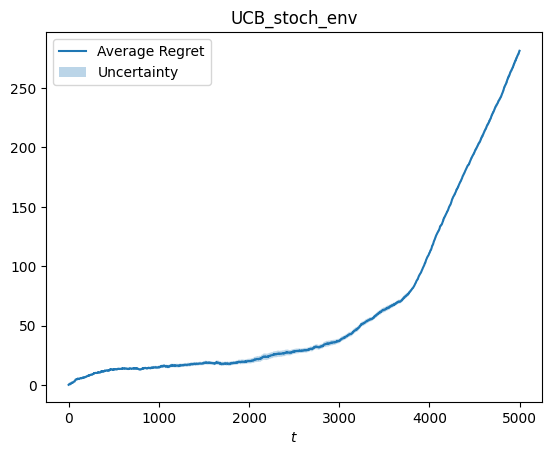

In [29]:
showPlotRegrets(R_TS, "UCB_stoch_env",args.T*args.n_users ,n_epochs)

[1.40269138e-01 1.40269138e-01 1.92912737e-01 ... 2.80961830e+02
 2.81048680e+02 2.81285441e+02]
[0.16651145 0.16651145 0.20837151 ... 5.65712391 5.6885839  5.54848397]


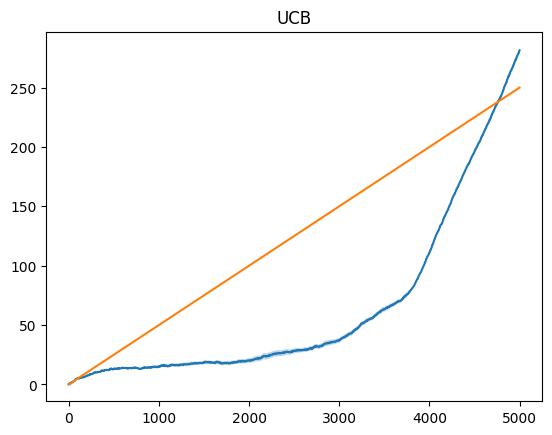

In [30]:
regret_per_trial = np.array(R_TS)
T = args.T*args.n_users
title = "UCB"
n_trials = n_epochs

average_regret = regret_per_trial.mean(axis=0)
print(average_regret)
regret_sd = regret_per_trial.std(axis=0)
print(regret_sd)
plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.plot(np.arange(T), 0.05*np.arange(T))
plt.title(title)
plt.fill_between(np.arange(T), average_regret - regret_sd / np.sqrt(n_trials),average_regret + regret_sd / np.sqrt(n_trials),alpha=0.3,label='Uncertainty')

plt.show()

[2.76397529e-01 2.76397529e-01 3.90420597e-01 ... 9.98846028e+02
 9.99009179e+02 9.99355751e+02]
[0.32731375 0.32731375 0.43263768 ... 0.60456069 0.33309264 0.22913208]


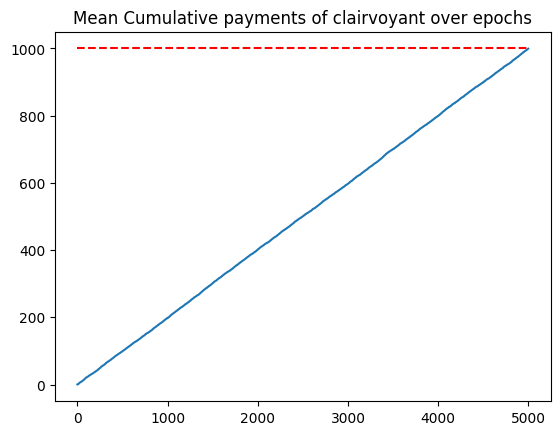

In [36]:
clairvoyant_payments_per_trial = np.array(clairvoyant_payments_arr)
T = args.T*args.n_users
title = "Mean Cumulative payments of clairvoyant over epochs"
n_trials = n_epochs

average_payments = clairvoyant_payments_per_trial.mean(axis=0)
print(average_payments)
payments_sd = clairvoyant_payments_per_trial.std(axis=0)
print(payments_sd)
plt.plot(np.arange(T), average_payments, label='Average Regret')
plt.title(title)
plt.hlines(args.B, 0, T, colors='r', linestyles='dashed', label='Budget')
plt.fill_between(np.arange(T), average_payments - payments_sd / np.sqrt(n_trials),average_payments + payments_sd / np.sqrt(n_trials),alpha=0.3,label='Uncertainty')

plt.show()

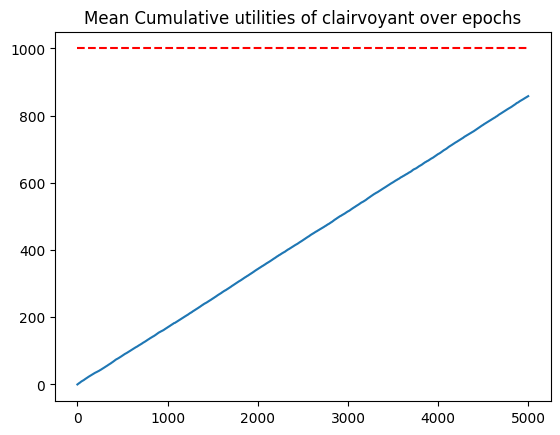

In [38]:
clairvoyant_utilities_per_trial = np.array(clairvoyant_utilities_arr)
T = args.T*args.n_users
title = "Mean Cumulative utilities of clairvoyant over epochs"
n_trials = n_epochs

average_utilities = clairvoyant_utilities_per_trial.mean(axis=0)
utilities_sd = clairvoyant_utilities_per_trial.std(axis=0)
plt.plot(np.arange(T), average_utilities, label='Average Regret')
plt.title(title)
plt.hlines(args.B, 0, T, colors='r', linestyles='dashed', label='Budget')
plt.fill_between(np.arange(T), average_utilities - utilities_sd / np.sqrt(n_trials),average_utilities + utilities_sd / np.sqrt(n_trials),alpha=0.3,label='Uncertainty')

plt.show()

In [16]:
best_agent_bid = np.argmax(average_regret)

In [17]:
def showPlotPulls(agent,title,K):
    plt.figure()
    plt.barh(np.arange(K), agent.N_pulls)
    #plt.axhline(best_price_index, color='red', label='Best price')
    plt.ylabel('actions')
    plt.xlabel('numer of pulls')
    plt.legend()
    plt.title('Number of pulls for each action '+title)
    plt.show()

/var/folders/33/rzdkhzl567j2mkrbw3cn1w080000gn/T/ipykernel_31550/1071916959.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


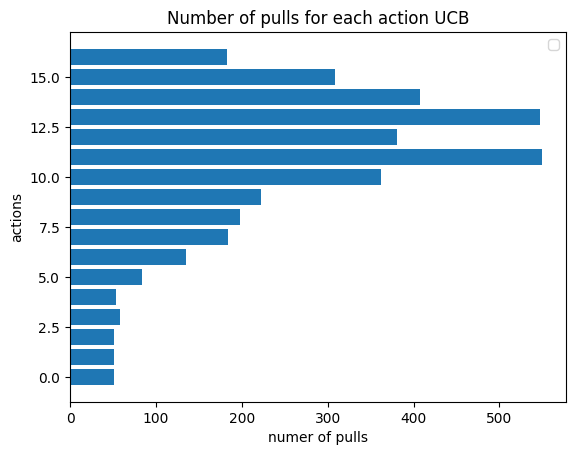

In [10]:
showPlotPulls( adv_agent,"UCB",len(adv_agent.N_pulls) )

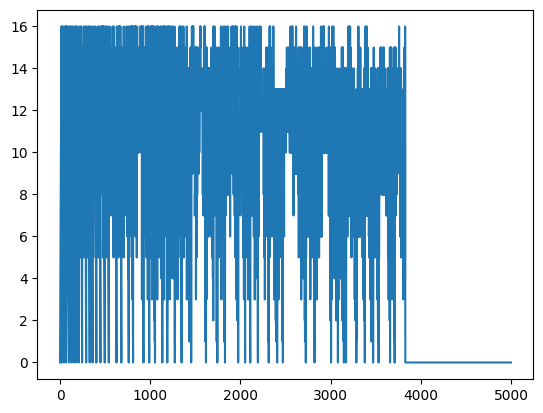

In [11]:
#plot arm history
plt.figure()
plt.plot(adv_agent.arm_history)

In [18]:
R_TS_multi = []
n_epochs = 25
args.bidding_agent = "multi"
args.T = 25
args.n_users = 1000

for n in range(n_epochs): 
    alg_utilities = np.array([])
    m_ts = np.array([])
    total_wins_period = 0
    auction, adv_agent = initialize_stoch_auctions(args)
    
    for t in range(args.T):
        day_seed = np.random.randint(0, 1000)
        np.random.seed(day_seed)
        other_bids = np.random.uniform(0, 1, size=(args.advertisers-1, args.n_users))
        
        utilities, my_bids, my_payments, total_wins = loop_auction_day(
            auction=auction, 
            agent=adv_agent, 
            other_bids=other_bids, 
            seed=day_seed,
            n_users=args.n_users
        )
        
        alg_utilities = np.append(alg_utilities, utilities)
        total_wins_period += total_wins
        m_t = other_bids.max(axis=0)
        m_ts = np.append(m_ts, m_t)
        
        adv_agent.update_per_round()
    
    print(f'Total # of Wins: {total_wins_period}')
    print(f'Total Bids: {args.T * args.n_users}') 

    clearvoyant_bids, clearvoyant_utilities, clairvoyant_payments = get_clairvoyant_truthful(
        args.B, args.valuation, m_ts, args.n_users * args.T
    )

    cumulative_regret = np.cumsum(clearvoyant_utilities - alg_utilities)
    R_TS_multi.append(cumulative_regret)

INITIALIZING MULTIPLICATIVE BIDDING AGENT...
Total # of Wins: 2737
Total Bids: 25000
INITIALIZING MULTIPLICATIVE BIDDING AGENT...
Total # of Wins: 2736
Total Bids: 25000
INITIALIZING MULTIPLICATIVE BIDDING AGENT...
Total # of Wins: 2741
Total Bids: 25000
INITIALIZING MULTIPLICATIVE BIDDING AGENT...
Total # of Wins: 2736
Total Bids: 25000
INITIALIZING MULTIPLICATIVE BIDDING AGENT...
Total # of Wins: 2737
Total Bids: 25000
INITIALIZING MULTIPLICATIVE BIDDING AGENT...
Total # of Wins: 2736
Total Bids: 25000
INITIALIZING MULTIPLICATIVE BIDDING AGENT...
Total # of Wins: 2741
Total Bids: 25000
INITIALIZING MULTIPLICATIVE BIDDING AGENT...
Total # of Wins: 2736
Total Bids: 25000
INITIALIZING MULTIPLICATIVE BIDDING AGENT...
Total # of Wins: 2737
Total Bids: 25000
INITIALIZING MULTIPLICATIVE BIDDING AGENT...
Total # of Wins: 2736
Total Bids: 25000
INITIALIZING MULTIPLICATIVE BIDDING AGENT...
Total # of Wins: 2741
Total Bids: 25000
INITIALIZING MULTIPLICATIVE BIDDING AGENT...
Total # of Wins: 273

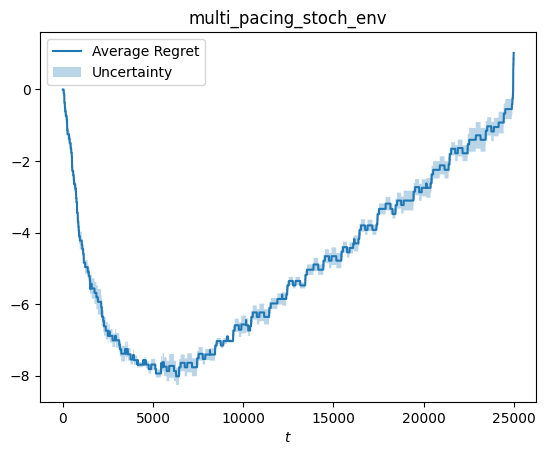

In [19]:
showPlotRegrets(R_TS_multi, "multi_pacing_stoch_env",args.T*args.n_users ,n_epochs)

[array([0.       , 0.       , 0.       , ..., 2.1003449, 2.1003449,
       2.1003449]), array([0.       , 0.       , 0.       , ..., 3.0101739, 3.0101739,
       3.0101739]), array([ 0.        , -0.5119216 , -0.5119216 , ...,  1.18444533,
        1.18444533,  1.18444533]), array([0.       , 0.       , 0.       , ..., 1.1800057, 1.1800057,
       1.1800057]), array([0.        , 0.        , 0.        , ..., 1.74560471, 1.74560471,
       1.74560471]), array([0.        , 0.        , 0.        , ..., 1.01218117, 1.01218117,
       1.01218117]), array([0.        , 0.        , 0.        , ..., 0.15683578, 0.15683578,
       0.15683578]), array([0.       , 0.       , 0.       , ..., 1.1800057, 1.1800057,
       1.1800057]), array([0.        , 0.        , 0.        , ..., 1.74560471, 1.74560471,
       1.74560471]), array([0.        , 0.        , 0.        , ..., 1.01218117, 1.01218117,
       1.01218117]), array([0.        , 0.        , 0.        , ..., 0.15683578, 0.15683578,
       0.156835

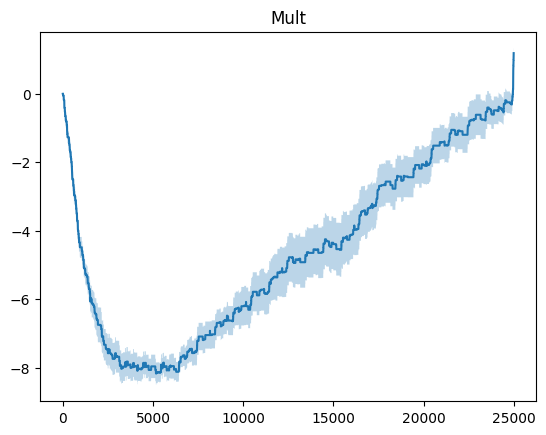

In [14]:
print(R_TS_multi)
regret_per_trial = np.array(R_TS_multi)
T = args.T*args.n_users
title = "Mult"
n_trials = n_epochs

average_regret = regret_per_trial.mean(axis=0)
print(average_regret)
regret_sd = regret_per_trial.std(axis=0)
print(regret_sd)
plt.plot(np.arange(T), average_regret, label='Average Regret')
#plt.plot(np.arange(T), 0.05*np.arange(T))
plt.title(title)
plt.fill_between(np.arange(T), average_regret - regret_sd / np.sqrt(n_trials),average_regret + regret_sd / np.sqrt(n_trials),alpha=0.3,label='Uncertainty')

plt.show()

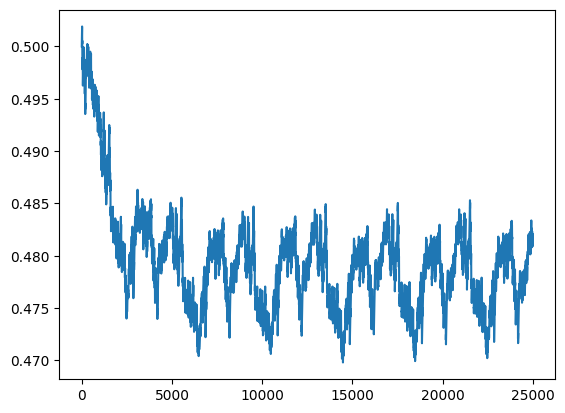

In [15]:
#plot arm history
plt.figure()
plt.plot(adv_agent.bid_history)